In [1]:
import pandas as pd
from Bio import SeqIO
import re
import json
import numpy as np
import matplotlib.pyplot as plt
# reload all changed moduels
%load_ext autoreload
%autoreload 2   


In [30]:
from utils import Utils
from process_data import ProcessData

data_dir = '../data'
client = ProcessData(data_dir)

## ATCC protein sequences and incubation temperature

### retrieve meta data

In [32]:
# source data: retrieve genome report from '../data/prokaryotes.txt'
client.genome_report_atcc('../data/prokaryotes.txt')

Number of genome: 2221


In [33]:
# sprawl HTML from ATCC and update incubation temperature
client.retrieve_atcc('../data/atcc')

parse strains=1856, failed in download=158


In [36]:
# check meta_data
meta_data = client.get_meta()
for item in meta_data:
    if '27343' in item['ATCC_No']:
        print(item)

{'#Organism/Name': 'Mycoplasma capricolum subsp. capricolum ATCC 27343', 'TaxID': 340047, 'BioProject Accession': 'PRJNA16208', 'BioProject ID': 16208, 'Group': 'Terrabacteria group', 'SubGroup': 'Mycoplasmatota', 'Size (Mb)': 1.01002, 'GC%': '23.8', 'Replicons': 'chromosome:NC_007633.1/CP000123.1', 'WGS': '-', 'Scaffolds': '1', 'Genes': '878', 'Proteins': '825', 'Release Date': '2005/12/06', 'Modify Date': '2021/11/29', 'Status': 'Complete Genome', 'Center': 'J. Craig Venter Institute', 'BioSample Accession': 'SAMN02603434', 'Assembly Accession': 'GCA_000012765.1', 'Reference': 'REPR', 'FTP Path': 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/012/765/GCA_000012765.1_ASM1276v1', 'Pubmed ID': '-', 'Strain': 'ATCC 27343', 'ATCC_No': '27343'}


In [37]:
# output: data/genome_report.joson -> ../data/temperature_mask
json_file = Utils.to_json(meta_data, outdir, 'genome_report_atcc.json')
print(json_file)

../data/genome_report_atcc.json


### analyze genome report

In [43]:
# 
from collections import Counter
temp = [max(item['incubation_temperature']) for item in meta_data if 'incubation_temperature' in item]

temp2 = dict(sorted(Counter(temp).items(), key=lambda x: x[0]))
temp2

{4: 1,
 5: 1,
 10: 1,
 15: 8,
 18: 5,
 20: 12,
 22: 1,
 23: 1,
 24: 2,
 25: 3,
 26: 342,
 27: 1,
 28: 7,
 29: 1,
 30: 285,
 34: 1,
 35: 23,
 37: 1133,
 40: 1,
 45: 1,
 50: 2,
 55: 6,
 60: 5,
 65: 1,
 70: 5,
 80: 4}

In [44]:
[item for item in meta_data if 'incubation_temperature' in item and item['incubation_temperature'] == [4]]

[{'#Organism/Name': 'Polaribacter filamentus',
  'TaxID': 53483,
  'BioProject Accession': 'PRJNA355329',
  'BioProject ID': 355329,
  'Group': 'FCB group',
  'SubGroup': 'Bacteroidota/Chlorobiota group',
  'Size (Mb)': 4.28193,
  'GC%': '31.4',
  'Replicons': '-',
  'WGS': 'MQUA01',
  'Scaffolds': '15',
  'Genes': '3918',
  'Proteins': '3669',
  'Release Date': '2018/02/26',
  'Modify Date': '2022/07/17',
  'Status': 'Contig',
  'Center': 'Atmosphere and Ocean Research Institute, The University of Tokyo',
  'BioSample Accession': 'SAMN06074323',
  'Assembly Accession': 'GCA_002943715.1',
  'Reference': 'REPR',
  'FTP Path': 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/002/943/715/GCF_002943715.1_ASM294371v1',
  'Pubmed ID': '-',
  'Strain': 'ATCC 700397',
  'ATCC_No': '700397',
  'incubation_temperature': [4]}]

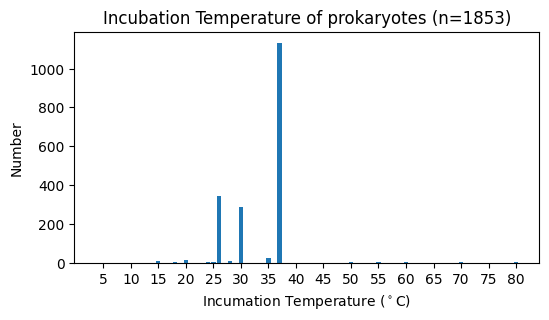

In [41]:
plt.figure(figsize=(6,3))
plt.bar(list(temp2), temp2.values())
plt.title(f"Incubation Temperature of prokaryotes (n={len(temp)})")
plt.xlabel("Incumation Temperature ($^\circ$C)")
plt.ylabel("Number")
plt.xticks(range(5,81,5))
plt.show()

In [45]:
for item in meta_data:
    print(item['FTP Path'])
    break

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/215/245/GCA_900215245.1_IMG-taxon_2617270901_annotated_assembly


## prepare protein

In [46]:
# prepare protein ~ temperature data
data_dir = '../data'
client = ProcessData(data_dir)
aa_meta = client.collect_meta()
print('Number of species in genome report: ', len(aa_meta))
print(aa_meta['Pseudomonas fluorescens'])

4442
Number of species in genome report:  1083
('Pseudomonas fluorescens', ['26'], '/home/yuan/data/ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001/414/285/GCF_001414285.1_ATCC948-1/GCF_001414285.1_ATCC948-1_protein.faa.gz')


In [48]:
client.prepare_aa(aa_meta)

species=1083, proteins=1590198


In [49]:
# check protein sequence of a certain genome
import gzip
infile = '/home/yuan/data/ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/117/375/GCA_900117375.1_SSCIU/GCA_900117375.1_SSCIU_translated_cds.faa.gz'
with gzip.open(infile, 'rt') as f:
    for rec in SeqIO.parse(f, 'fasta'):
        print(rec.description)
        break

lcl|FPED01000005.1_prot_SFV45968.1_1 [locus_tag=SSCIU_02811] [protein=Hypothetical protein] [protein_id=SFV45968.1] [location=complement(193..558)] [gbkey=CDS]


In [50]:
# prepare protein ~ temperature data for masked models
# output: data/temperature_mask/temperature_mask.txt
client.prepare_aa_mask(aa_meta)

species=1083, proteins=1590198


## uniportKB annotations
input: uniprot_sprot.dat.gz

In [54]:
# amino acids in sequence > 24
n=0
kmer=512
# 
infile = '/home/yuan/data/UniProt/uniprot_sprot.dat.gz'
rec_iter = Utils.iter_uniprot(infile)

# 
outdir = '../data'
out_txt = f'{outdir}/uniprot_sprot.txt'
mask_txt = f'{outdir}/temperature_mask/uniprot_sprot_mask.txt'
with open(out_txt, 'w') as OUT, open(mask_txt, 'w') as MASK:
    for rec in rec_iter:
        annot, temp = None, None
        annot = rec.annotations
        _seq = str(rec.seq)
        if 'comment' in annot:
            for i in annot['comment'].split('; '):
                temp = re.findall(r'Optimum temperature is (\d+-\d+|\d+)', i)
                # if rec.id == 'Q8YYI3':
                #     print(temp, i)
                if temp and len(_seq) > 24:
                    # annotations
                    i=i.replace('\t', '')
                    desc=rec.description.replace('\t', '')
                    items = [_seq, temp[0], rec.id]
                    line = '\t'.join(items)
                    OUT.write(line+"\n")
                    # mask file
                    temp = np.max([int(t) for t in temp[0].split('-')])
                    if len(_seq) > kmer:
                        for j in range(0, len(_seq)-kmer):
                            MASK.write(f"{_seq[j:j+kmer]} is {temp}\n")    
                    else:
                        MASK.write(f"{_seq} is {temp}\n")
                    n += 1
                    break
print(f"Total UniProt-Sprot protein: {n}.")

Total UniProt-Sprot protein: 2177.


In [56]:
from collections import Counter, OrderedDict

counts, info = {}, {}
with open(out_txt, 'r') as f:
    for line in f:
        line = line.rstrip()
        aa, aa_temp, acc = line.split('\t')
        temp = int(aa_temp.split('-')[-1])
        if temp not in counts:
            counts[temp] = Counter()
            info[temp] = 0
        counts[temp].update(aa)
        info[temp] += 1
cdf = pd.DataFrame(counts).fillna(0).sort_index().sort_index(axis=1)
print(cdf.shape)
print(cdf)

(22, 83)
     4     7     9      10     15     16    18      20    21     22   ...  \
A  123.0  44.0  35.0  139.0  176.0   80.0   5.0  1046.0  43.0  560.0  ...   
C   26.0  12.0  11.0   22.0   23.0   15.0  14.0   226.0  12.0  152.0  ...   
D  124.0  23.0  37.0   87.0  101.0   60.0   5.0   660.0  26.0  413.0  ...   
E  117.0  37.0  33.0  113.0  100.0   71.0   6.0   725.0  48.0  450.0  ...   
F  102.0  33.0  25.0   67.0   74.0   37.0   6.0   493.0  25.0  324.0  ...   
G  128.0  29.0  39.0  104.0  146.0   71.0   8.0  1008.0  40.0  606.0  ...   
H   59.0   6.0  16.0   42.0   49.0   20.0   2.0   293.0   8.0  164.0  ...   
I  116.0  32.0  27.0   89.0   90.0   51.0   4.0   677.0  27.0  412.0  ...   
K   94.0  24.0  25.0   85.0   82.0   63.0  12.0   578.0  39.0  379.0  ...   
L  172.0  57.0  59.0  140.0  159.0  108.0   6.0  1134.0  49.0  616.0  ...   
M   34.0   9.0  23.0   33.0   31.0   25.0   2.0   273.0  15.0  183.0  ...   
N  117.0  17.0  14.0   68.0   79.0   35.0   4.0   514.0  19.0  307.

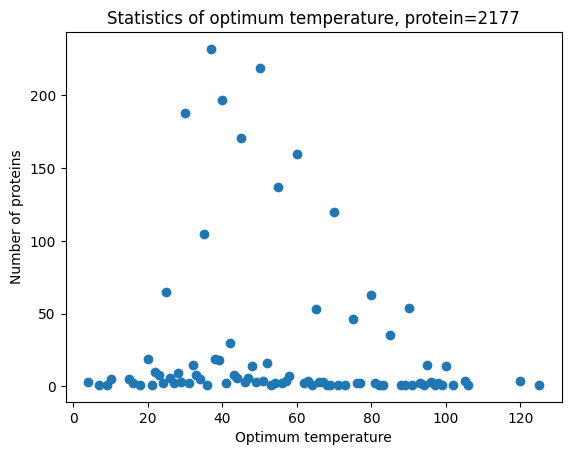

In [57]:
plt.scatter(info.keys(), info.values())
plt.title(f'Statistics of optimum temperature, protein={sum(info.values())}')
plt.xlabel('Optimum temperature')
plt.ylabel('Number of proteins')
plt.show()

In [58]:
per_cdf=cdf/cdf.sum(axis=0)
per_cdf

,4,7,9,10,15,16,18,20,21,22,...,96,97,98,99,100,102,105,106,120,125
A,0.061286,0.080882,0.063521,0.088591,0.100171,0.077519,0.040984,0.081649,0.077477,0.075279,...,0.110365,0.060241,0.056399,0.042857,0.067751,0.064455,0.069700,0.052083,0.091165,0.062257
C,0.012955,0.022059,0.019964,0.014022,0.013090,0.014535,0.114754,0.017641,0.021622,0.020433,...,0.001919,0.006024,0.003254,0.001299,0.004878,0.000948,0.004840,0.041667,0.015977,0.019455
D,0.061784,0.042279,0.067151,0.055449,0.057484,0.058140,0.040984,0.051518,0.046847,0.055518,...,0.054702,0.060241,0.047722,0.050649,0.052755,0.066351,0.053727,0.041667,0.044173,0.035019
E,0.058296,0.068015,0.059891,0.072020,0.056915,0.068798,0.049180,0.056592,0.086486,0.060492,...,0.081574,0.096386,0.097614,0.096104,0.099548,0.072986,0.080833,0.135417,0.079887,0.108949
F,0.050822,0.060662,0.045372,0.042702,0.042117,0.035853,0.049180,0.038483,0.045045,0.043554,...,0.028791,0.042169,0.032538,0.048052,0.044083,0.045498,0.050823,0.020833,0.039474,0.046693
G,0.063777,0.053309,0.070780,0.066284,0.083096,0.068798,0.065574,0.078682,0.072072,0.081463,...,0.099808,0.090361,0.072668,0.040260,0.069196,0.063507,0.070668,0.093750,0.092105,0.070039
H,0.029397,0.011029,0.029038,0.026769,0.027888,0.019380,0.016393,0.022871,0.014414,0.022046,...,0.013436,0.030120,0.024946,0.014286,0.019332,0.011374,0.020813,0.010417,0.013158,0.027237
I,0.057798,0.058824,0.049002,0.056724,0.051224,0.049419,0.032787,0.052845,0.048649,0.055384,...,0.058541,0.072289,0.072668,0.093506,0.080036,0.066351,0.063408,0.104167,0.056391,0.085603
K,0.046836,0.044118,0.045372,0.054175,0.046670,0.061047,0.098361,0.045117,0.070270,0.050948,...,0.067179,0.072289,0.075922,0.115584,0.076242,0.083412,0.064376,0.052083,0.054511,0.070039
L,0.085700,0.104779,0.107078,0.089229,0.090495,0.104651,0.049180,0.088518,0.088288,0.082807,...,0.081574,0.078313,0.099783,0.102597,0.088347,0.063507,0.106970,0.072917,0.078008,0.050584


In [59]:
from scipy import stats

def aa_corr(x, y):
    corr = stats.pearsonr(x, y)
    # print(dir(corr))
    return pd.Series([corr.statistic, corr.pvalue, corr.correlation])
print(list(per_cdf))
corr =  per_cdf.apply(aa_corr, y=list(per_cdf), axis=1)
corr = pd.DataFrame(corr)
corr.columns=['statistic', 'pvalue', 'correlation']
corr.index = list(per_cdf.index)
corr['hydrophobicity'] = np.nan
corr['group'] = ''
corr.loc[['L','I','F','W','V','M'], 'group'] = 'very hydrophobic'
corr.loc[['L','I','F','W','V','M'], 'hydrophobicity'] = [100,99,97,97,76,74]
corr.loc[['C','Y','A'], 'group'] = 'hydrophobic'
corr.loc[['C','Y','A'], 'hydrophobicity'] = [63,49,41]
corr.loc[['T','E','G','S','Q'], 'group'] = 'neutral'
corr.loc[['T','E','G','S','Q'], 'hydrophobicity'] = [13,8,0,-5,-10]
corr.loc[['R','K','N','H','P', 'D'], 'group'] = 'hydrophilic'
corr.loc[['R','K','N','H','P', 'D'], 'hydrophobicity'] = [-14,-23,-28,-31,-46,-55]
corr = corr.sort_values(by=['hydrophobicity',], ascending=False)
print(corr)

[4, 7, 9, 10, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 75, 76, 77, 80, 81, 82, 83, 85, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 105, 106, 120, 125]
   statistic        pvalue  correlation  hydrophobicity             group
L  -0.190661  8.425039e-02    -0.190661           100.0  very hydrophobic
I   0.528454  2.822863e-07     0.528454            99.0  very hydrophobic
W  -0.206078  6.160781e-02    -0.206078            97.0  very hydrophobic
F  -0.214756  5.121636e-02    -0.214756            97.0  very hydrophobic
V   0.429334  5.119469e-05     0.429334            76.0  very hydrophobic
M  -0.028260  7.997983e-01    -0.028260            74.0  very hydrophobic
C  -0.219169  4.651228e-02    -0.219169            63.0       hydrophobic
Y   0.250597  2.231181e-02     0.250597            49.0       hydrophobi

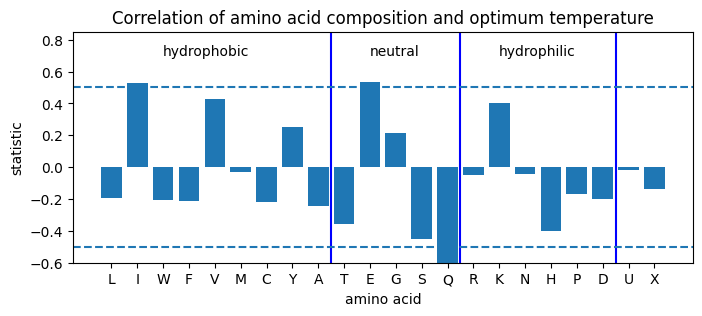

In [60]:
fig = plt.subplots(figsize=(8,3))
plt.bar(list(corr.index), corr.statistic)
plt.xlabel('amino acid')
plt.ylabel('statistic')
plt.title('Correlation of amino acid composition and optimum temperature')
plt.axvline(x = 8.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axvline(x = 13.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axvline(x = 19.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axhline(y=.5, ls='--')
plt.axhline(y=-.5, ls='--')
plt.ylim(-0.6, 0.85)
plt.text(2,.7, 'hydrophobic')
plt.text(10,.7, 'neutral')
plt.text(15,.7, 'hydrophilic')
plt.show()